UCEC Reccurance Notebook

Importing data from ucec_tcga_pan_can_atlas_2018

In [62]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt


In [63]:
mrna_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")
# I appear to have 527 patients in the mRNA and 529 patients in the clinical data

clinical_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
clinical_df = clinical_df.set_index('PATIENT_ID')

# The first 2 columns of the mRNA data are labels. 13 of the genes do not have Hugo_symbols, so I am putting placeholder stings as labels for these genes
missing_symbols = mrna_df['Hugo_Symbol'].isnull()
mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = [
    f'no_symbol_{i+1}' for i in range(missing_symbols.sum())
]

# Get value counts
counts = mrna_df['Hugo_Symbol'].value_counts()

# Generate unique labels for duplicates
def label_duplicates(value, index):
    if counts[value] == 1:
        return value  # Keep unique values unchanged
    occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
    return f"{value}-{occurrence[index]}-of-{counts[value]}"

# Apply the labeling function
mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

mrna_df = mrna_df.set_index('Hugo_Symbol')
mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
mrna_df_transposed= mrna_df.transpose()
mrna_df_transposed.index = [id[:-3] for id in mrna_df_transposed.index] # removes extranious -01 so that the patient ids match the clinical data

df = clinical_df.join(mrna_df_transposed, how='inner') # this is the data frame for clinical and genetic data. It has 527 patients (rows) and 20568 features (columns).

The following genes appear in the data more than once but have different data: 
['PALM2AKAP2', 'ELMOD1', 'FGF13', 'QSOX1', 'SNAP47', 'NKAIN3', 'TMEM8B']
Right now, I'm leaving every version of the gene in, but giving placeholder unique names like: PALM2AKAP2-1-of-2 and PALM2AKAP2-2-of-2

Removing unecessary columns from clinical data.

In [64]:
MAX_NULL_VALS = 0.3

def assign_label(row):
    '''given a row assigns 1 for recurrance and 0 for no recurrance. 
    Currently uses NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT to identify recurrance.
    If NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT is NaN, uses DSF_STATUS'''
    if row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'Yes':
        return 1
    elif row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'No':
        return 0
    elif pd.isna(row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT']):
        if row['DFS_STATUS'] == '1:Recurred/Progressed':
            return 1
        elif row['DFS_STATUS'] == '0:DiseaseFree':
            return 0
        else:
            raise ValueError(f"Error: Both columns are NaN at index {row.name}")

for col in df.columns:
    unique_values = df[col].nunique(dropna=True)
    if unique_values <= 1:
        # print(f"Removing column: {col}")
        df.drop(columns=[col], inplace=True)

# remove the column is over MAX_NULL_VALS percent null values
df.dropna(axis=1, thresh=len(df) * (1 - MAX_NULL_VALS))

# remove non-informational columns
df = df.drop(columns=['OTHER_PATIENT_ID'])

pair_counts = df.groupby(["NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT", 'DFS_STATUS'], dropna=False).size().reset_index(name='Count')

# Print the pairings and the count
print(pair_counts)

# I am going to remove the 32 rows where we have no recurrance label (neither NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT nor DFS_STATUS are known)
# PFS_STATUS
df = df.dropna(subset=['DFS_STATUS', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'], how='all')

# # numpy array for the Labels for recurrance
labels = np.array(df.apply(assign_label, axis=1)) 
#DIF DFI.time 

  NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT             DFS_STATUS  Count
0                                      No          0:DiseaseFree    326
1                                      No  1:Recurred/Progressed     12
2                                      No                    NaN     49
3                                     Yes          0:DiseaseFree      7
4                                     Yes  1:Recurred/Progressed     38
5                                     Yes                    NaN     34
6                                     NaN          0:DiseaseFree     24
7                                     NaN  1:Recurred/Progressed      5
8                                     NaN                    NaN     32


Transforms data by changing catagorical data into numerical data and filling in missing data points with medians or modes.

In [65]:
categorical_columns = ["ETHNICITY",
                        "ICD_10", 
                        "PRIOR_DX", 
                        "RACE",
                        "RADIATION_THERAPY", 
                        "IN_PANCANPATHWAYS_FREEZE", 
                        "GENETIC_ANCESTRY_LABEL"] #FIXME: do further research on what ICD_10 and ICD_O_3_SITE are

#FIXME: I will need to go through the numerical categories and see if any need to be removed (because they represent data from after initial treatment)
# Fill numerical NaNs with median
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['OS_MONTHS', 'DSS_MONTHS', 'DFS_MONTHS', 'PFS_MONTHS'])
numerical_df = numerical_df.fillna(numerical_df.median())

# fill catagorical columns with mode
categorical_df = df[categorical_columns]
categorical_df = categorical_df.fillna(categorical_df.mode())


# One-Hot Encode categorical columns (drop first to avoid redundancy)
categorical_df = pd.get_dummies(categorical_df, drop_first=True, dtype=float)

X = pd.concat([numerical_df, categorical_df], axis=1)
X = X.to_numpy()


# Part 2: Training My Model

RandomForestClassifer (currently massively overfitting, but we're working on it)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

def run_random_forest_classifer():
    # Code for training Random Forest
    print("Running random forest classifier")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.0)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('clf', RandomForestClassifier(random_state=100, class_weight='balanced'))
    ])

    # Define hyperparameter grid
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [None, 5, 10, 15],
        'clf__min_samples_split': [2, 4],
        'select__k': [50, 100, 500]
    }

def run_logistic_regression():
    # Define the pipeline with Logistic Regression
    print("Running Logistic Regression")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.0)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(class_weight='balanced', random_state=100))
    ])

    # define hyperparameter grid for logistic regression
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'select__k': [50, 100, 500]
    }

# Change which model you are using here
run_logistic_regression()

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_


Best params: {'clf__C': 0.01, 'select__k': 50}


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 4354  8220 12187 12260 12415 12502 12892 13603 16431 19148] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [67]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_search.best_params_
print("best params: ", best_params)

best_model = grid_search.best_estimator_


best params:  {'clf__C': 0.01, 'select__k': 500}


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 4783  6653 12260 12415 12424 12466 12488 12502 12526 17250 18227 20036] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [73]:
# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Parameters: {'clf__C': 0.01, 'select__k': 50}
Mean AUC-ROC: 0.6244
Standard Deviation: 0.0594
------------------------------
Parameters: {'clf__C': 0.01, 'select__k': 100}
Mean AUC-ROC: 0.6232
Standard Deviation: 0.0691
------------------------------
Parameters: {'clf__C': 0.01, 'select__k': 500}
Mean AUC-ROC: 0.6125
Standard Deviation: 0.0700
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 50}
Mean AUC-ROC: 0.5762
Standard Deviation: 0.0640
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 100}
Mean AUC-ROC: 0.5819
Standard Deviation: 0.0447
------------------------------
Parameters: {'clf__C': 0.1, 'select__k': 500}
Mean AUC-ROC: 0.5858
Standard Deviation: 0.0540
------------------------------
Parameters: {'clf__C': 1, 'select__k': 50}
Mean AUC-ROC: 0.5405
Standard Deviation: 0.0616
------------------------------
Parameters: {'clf__C': 1, 'select__k': 100}
Mean AUC-ROC: 0.5581
Standard Deviation: 0.0461
------------------------------
Para

Analyzing the prediction of the training data

[0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0
 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0
 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
True Positives (TP): 53
False Positives (FP): 70
True Negatives (TN): 258
False Negatives (FN): 15
AUC-ROC Score: 0.7830


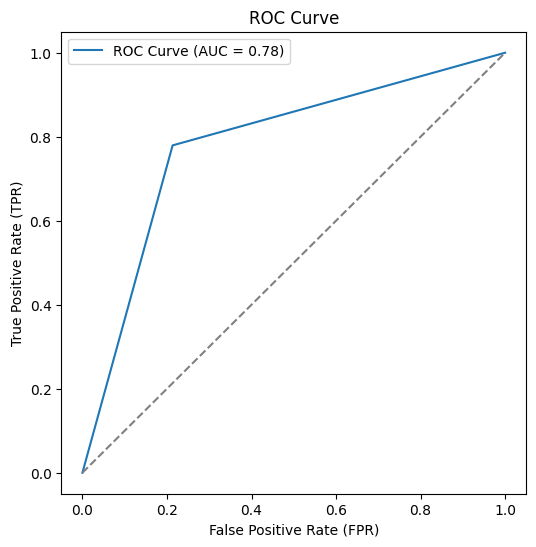

In [74]:
y_train_pred = best_model.predict(X_train)

print(y_train_pred)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

Analyzing the performace on the training data

[0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1
 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1]
True Positives (TP): 8
False Positives (FP): 26
True Negatives (TN): 57
False Negatives (FN): 8
AUC-ROC Score: 0.5934


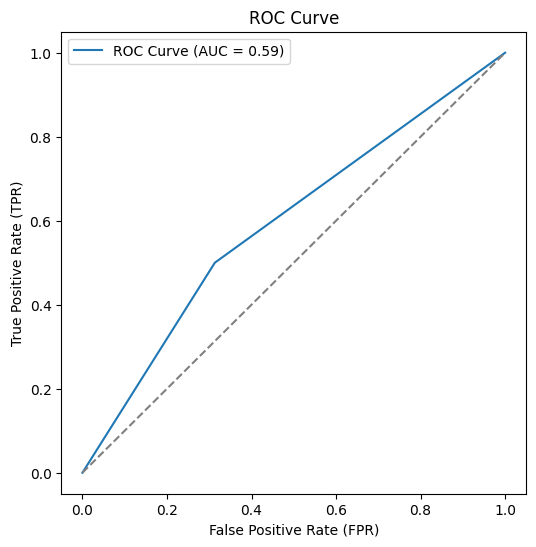

In [75]:
y_test_pred = best_model.predict(X_test)

print(y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()